### У цьому ноутбуку ми розглянемо:

Perceptron (класичний варіант - з пороговою функцією активації і дельта-правилом для навчання)

Multi-layer Perceptron (багатошарова нейронна мережа - узагальнення персептрона для більш складних задач)



### Датасет - класифікація зображень рукописних цифр (MNIST)

https://www.kaggle.com/competitions/digit-recognizer/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


plt.rcParams['image.cmap'] = 'gray'

import torch
import torch.nn as nn

In [2]:
train = pd.read_csv("train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


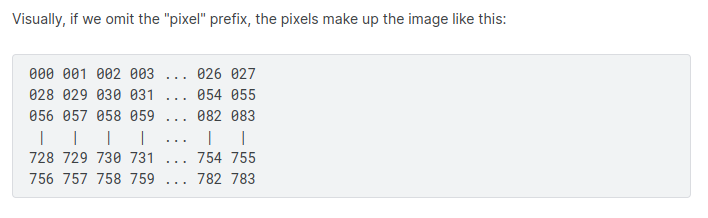

In [3]:
from IPython.display import Image
Image("description.png")

In [4]:
x_cols = train.columns.difference(['label'])
target = 'label'

In [5]:
X = (train.iloc[:,1:].values).astype('float32') # all pixel values
y = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits

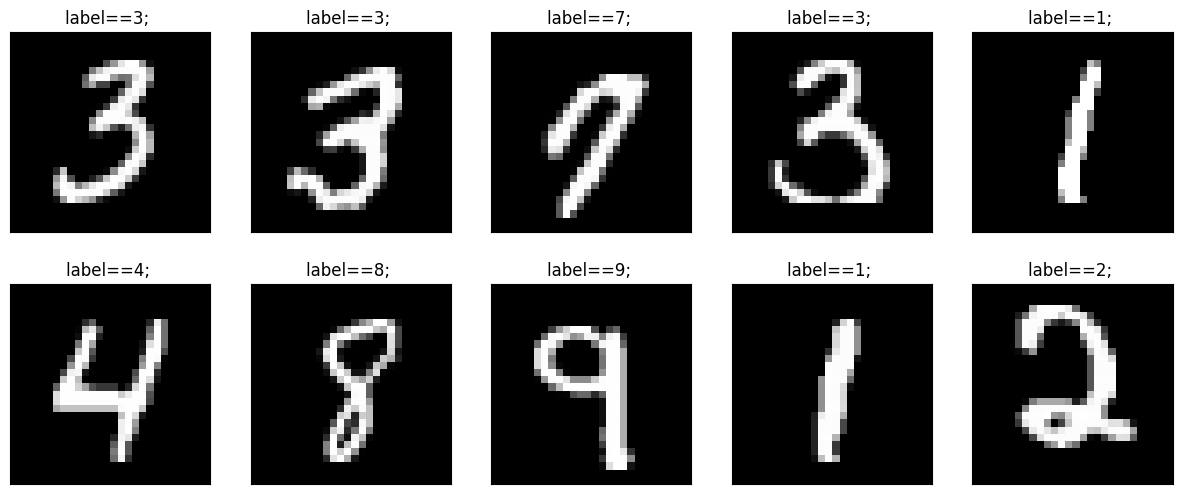

In [6]:
def visualize(X, y, y_pred = None, n_rows=2, n_columns=5):
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(n_columns*3, n_rows*3))
    images = X.reshape(len(X), 28, 28)
    for i in range(n_rows):
        for j in range(n_columns):
            ind = np.random.randint(len(X))
            image, label = images[ind], y[ind]
            axs[i][j].imshow(image); 
            title = f"label=={label}; "
            if y_pred is not None:
                title += f"Predicted=={y_pred[ind]}"
            axs[i][j].set_title(title); 
            axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
            
visualize(X,y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=y, test_size=0.2)

### Деякі методи нативно підтримують багатокласову класифікацію

Зокрема, метод найближчого сусіда працює із будь-якою множиною класів

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [9]:
y_knn = knn.predict(X_val)
print(classification_report(y_val, y_knn))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       827
           1       0.95      0.99      0.97       937
           2       0.98      0.94      0.96       835
           3       0.97      0.97      0.97       870
           4       0.97      0.96      0.97       814
           5       0.96      0.96      0.96       759
           6       0.97      0.99      0.98       827
           7       0.96      0.97      0.97       880
           8       0.99      0.94      0.96       813
           9       0.95      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



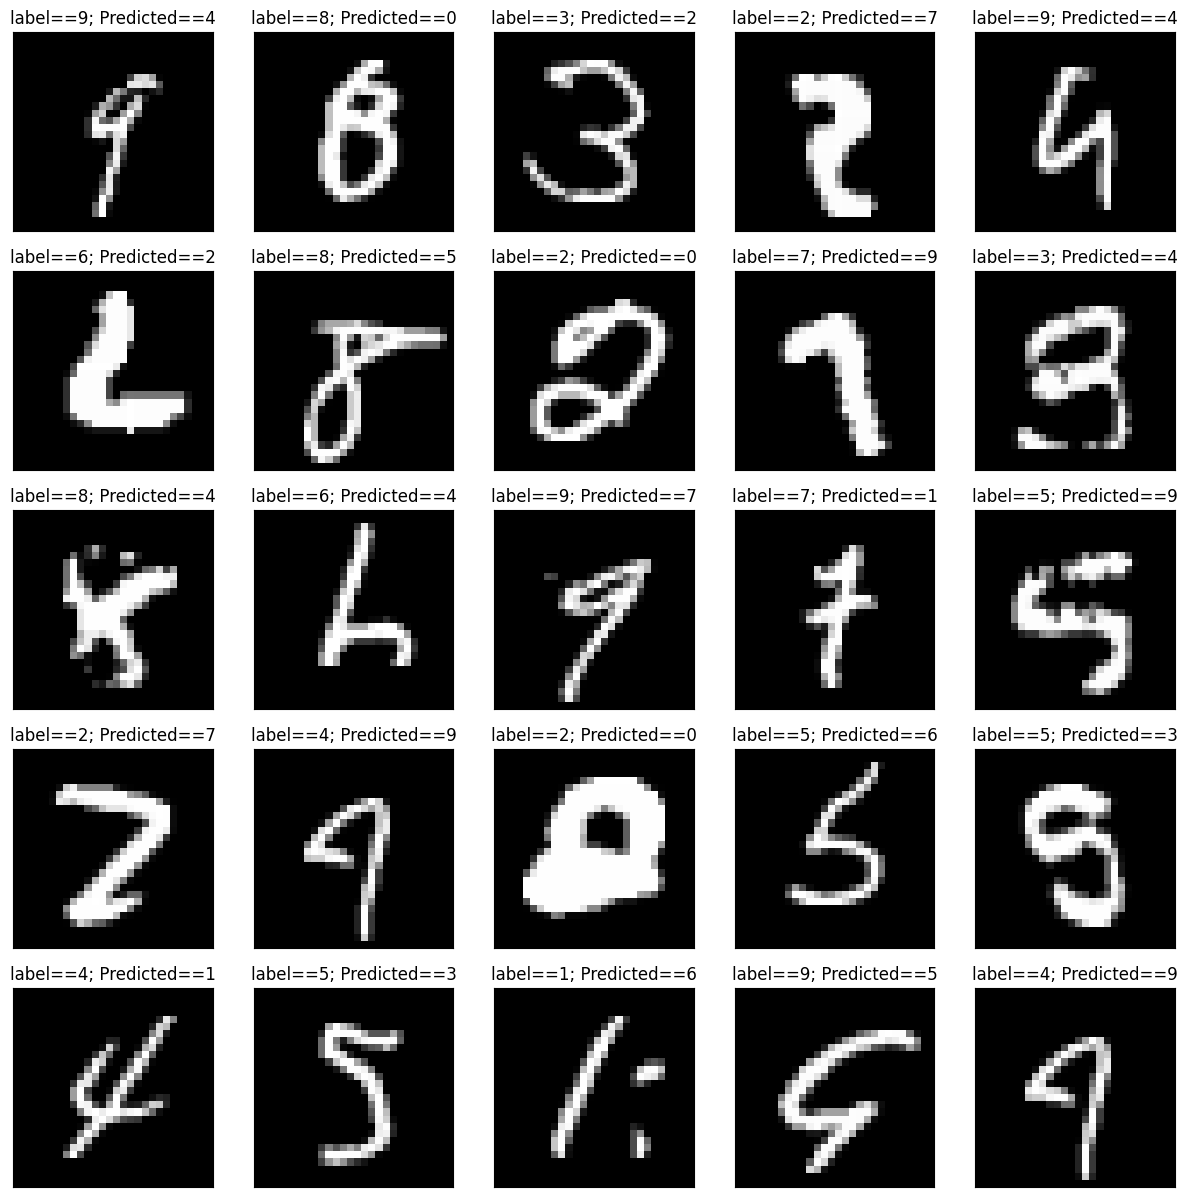

In [10]:
visualize(X_val[y_val!= y_knn], 
          y_val[y_val!=y_knn], 
          y_knn[y_val!=y_knn], n_rows=5, n_columns=5)

### В чистому вигляді персептрон - це алгоритм, призначений для класифікації (під 10 класів-цифр напряму не вийде застосувати)

Однак є обхідні шляхи - стратегії One-Vs-Rest, One-Vs-One

In [11]:
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

one_vs_rest = OneVsRestClassifier(Perceptron())
one_vs_rest.fit(X_train, y_train)

OneVsRestClassifier(estimator=Perceptron())

На стратегії one_vs_rest - ми будуємо 10 бінарних класифікаторів.

{0 vs інші}, {1 vs інші}.. {9 vs інші}

In [12]:
len(one_vs_rest.estimators_)

10

In [13]:
from sklearn.metrics import classification_report
y_onevsrest = one_vs_rest.predict(X_val)
print(classification_report(y_val, y_onevsrest))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       827
           1       0.92      0.97      0.95       937
           2       0.93      0.81      0.86       835
           3       0.85      0.87      0.86       870
           4       0.90      0.91      0.91       814
           5       0.78      0.82      0.80       759
           6       0.86      0.99      0.92       827
           7       0.93      0.85      0.89       880
           8       0.88      0.71      0.78       813
           9       0.80      0.89      0.84       838

    accuracy                           0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400



Візуалізуємо приклади де алгоритм помилився

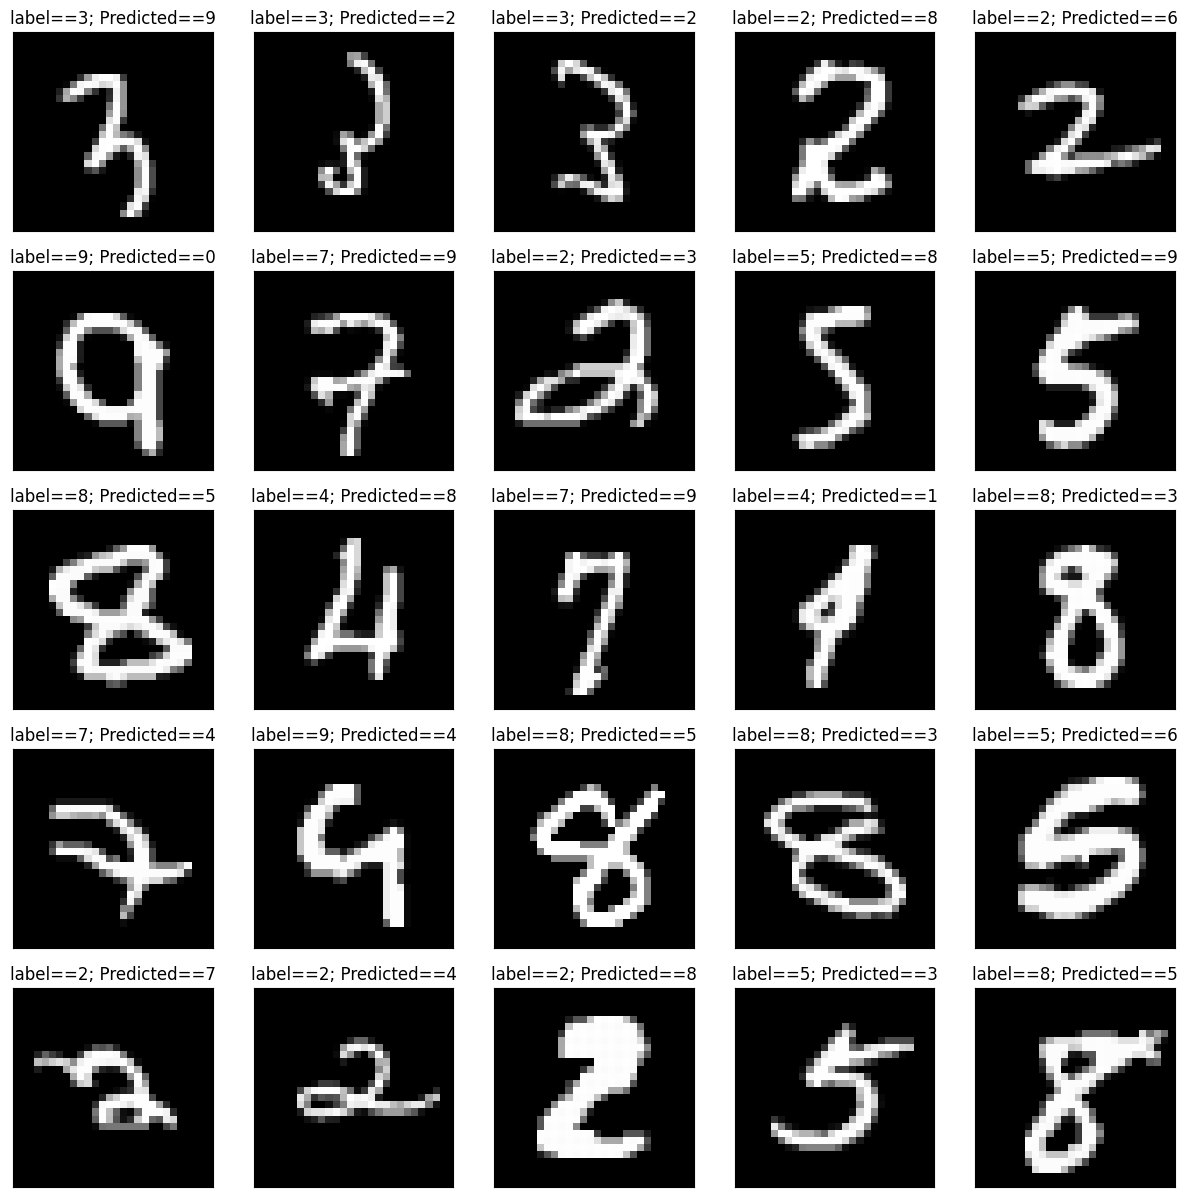

In [14]:
visualize(X_val[y_val != y_onevsrest], 
          y_val[y_val!=y_onevsrest], 
          y_onevsrest[y_val!=y_onevsrest], n_rows=5, n_columns=5)

In [15]:
one_vs_one = OneVsOneClassifier(Perceptron())
one_vs_one.fit(X_train, y_train)

OneVsOneClassifier(estimator=Perceptron())

In [16]:
len(one_vs_one.estimators_) # 10*9/2

45

In [17]:
y_onevsone = one_vs_one.predict(X_val)
print(classification_report(y_val, y_onevsone))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       827
           1       0.98      0.94      0.96       937
           2       0.90      0.89      0.90       835
           3       0.89      0.90      0.90       870
           4       0.90      0.94      0.92       814
           5       0.86      0.91      0.88       759
           6       0.97      0.96      0.97       827
           7       0.95      0.90      0.93       880
           8       0.84      0.90      0.87       813
           9       0.90      0.87      0.88       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



Візуалізуємо приклади де алгоритм помилився

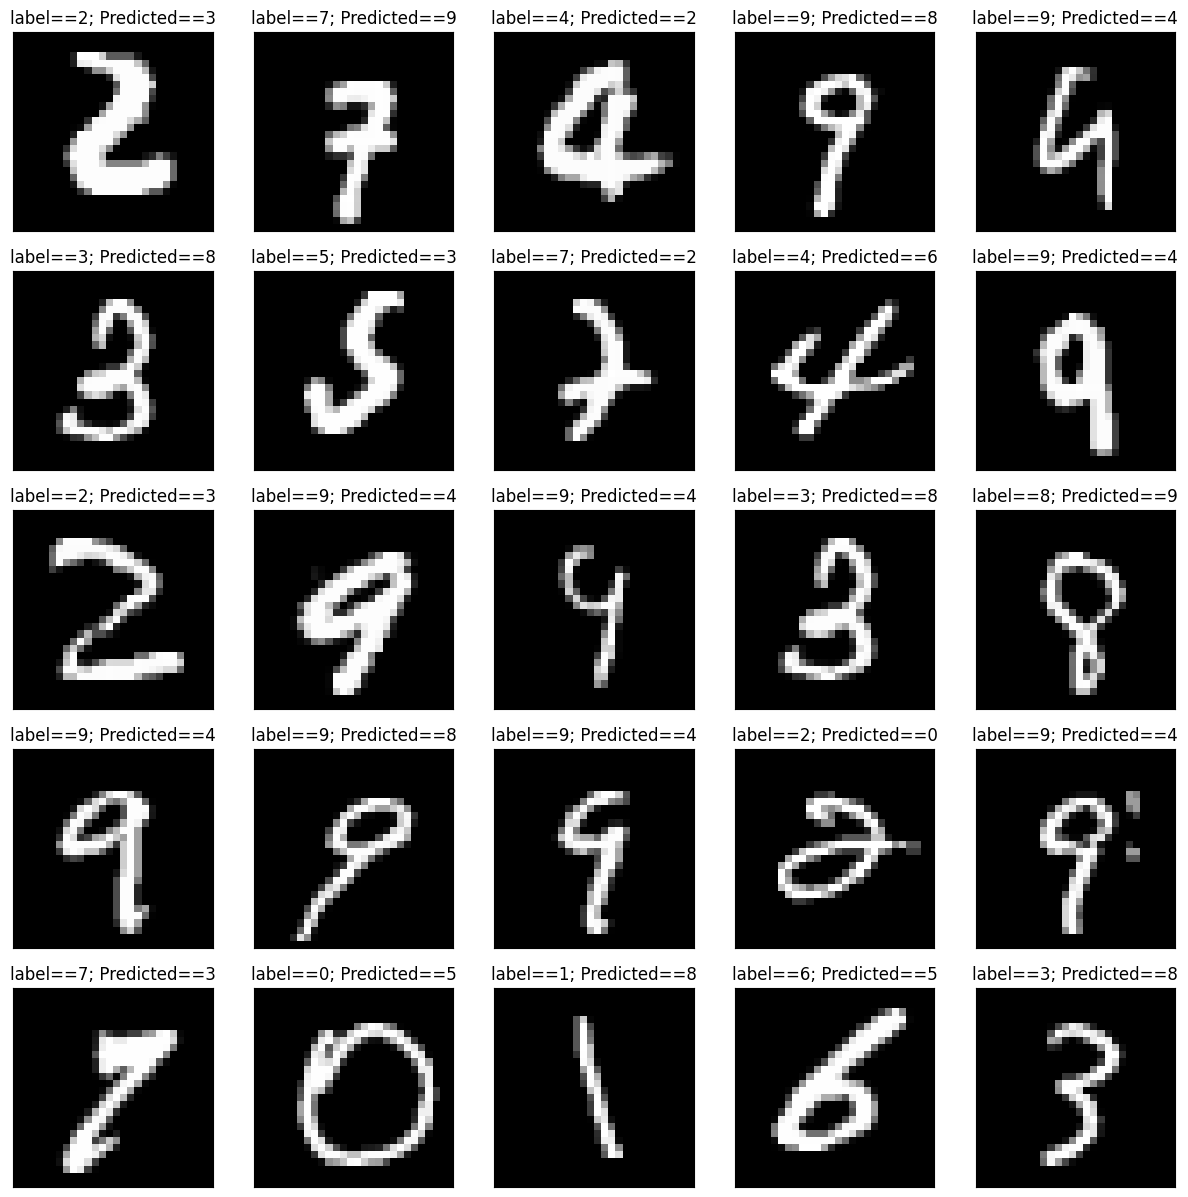

In [18]:
visualize(X_val[y_val != y_onevsone], y_val[y_val!=y_onevsone], 
          y_onevsone[y_val!=y_onevsone], n_rows=5, n_columns=5)

### Розглянемо Multi-layer-perceptron (реалізація sklearn)

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', verbose=1)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.85954598
Iteration 2, loss = 0.45205179
Iteration 3, loss = 0.38236912
Iteration 4, loss = 0.35283951
Iteration 5, loss = 0.32263531
Iteration 6, loss = 0.31282335
Iteration 7, loss = 0.30848027
Iteration 8, loss = 0.30634894
Iteration 9, loss = 0.30248885
Iteration 10, loss = 0.27876420
Iteration 11, loss = 0.28063311
Iteration 12, loss = 0.27640060
Iteration 13, loss = 0.27272340
Iteration 14, loss = 0.27315160
Iteration 15, loss = 0.26292042
Iteration 16, loss = 0.26679504
Iteration 17, loss = 0.24846613
Iteration 18, loss = 0.23986340
Iteration 19, loss = 0.24051621
Iteration 20, loss = 0.23769852
Iteration 21, loss = 0.24643163
Iteration 22, loss = 0.24819208
Iteration 23, loss = 0.22971997
Iteration 24, loss = 0.23623918
Iteration 25, loss = 0.23774347
Iteration 26, loss = 0.24561395
Iteration 27, loss = 0.22880828
Iteration 28, loss = 0.22745681
Iteration 29, loss = 0.23375376
Iteration 30, loss = 0.21736922
Iteration 31, loss = 0.23347883
Iteration 32, los

MLPClassifier(activation='tanh', verbose=1)

In [20]:
y_mlp = mlp.predict(X_val)
print(classification_report(y_val, y_mlp))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       827
           1       0.98      0.98      0.98       937
           2       0.93      0.94      0.94       835
           3       0.95      0.90      0.92       870
           4       0.96      0.93      0.94       814
           5       0.93      0.92      0.92       759
           6       0.97      0.97      0.97       827
           7       0.95      0.95      0.95       880
           8       0.92      0.95      0.93       813
           9       0.91      0.94      0.92       838

    accuracy                           0.95      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.95      0.95      0.95      8400



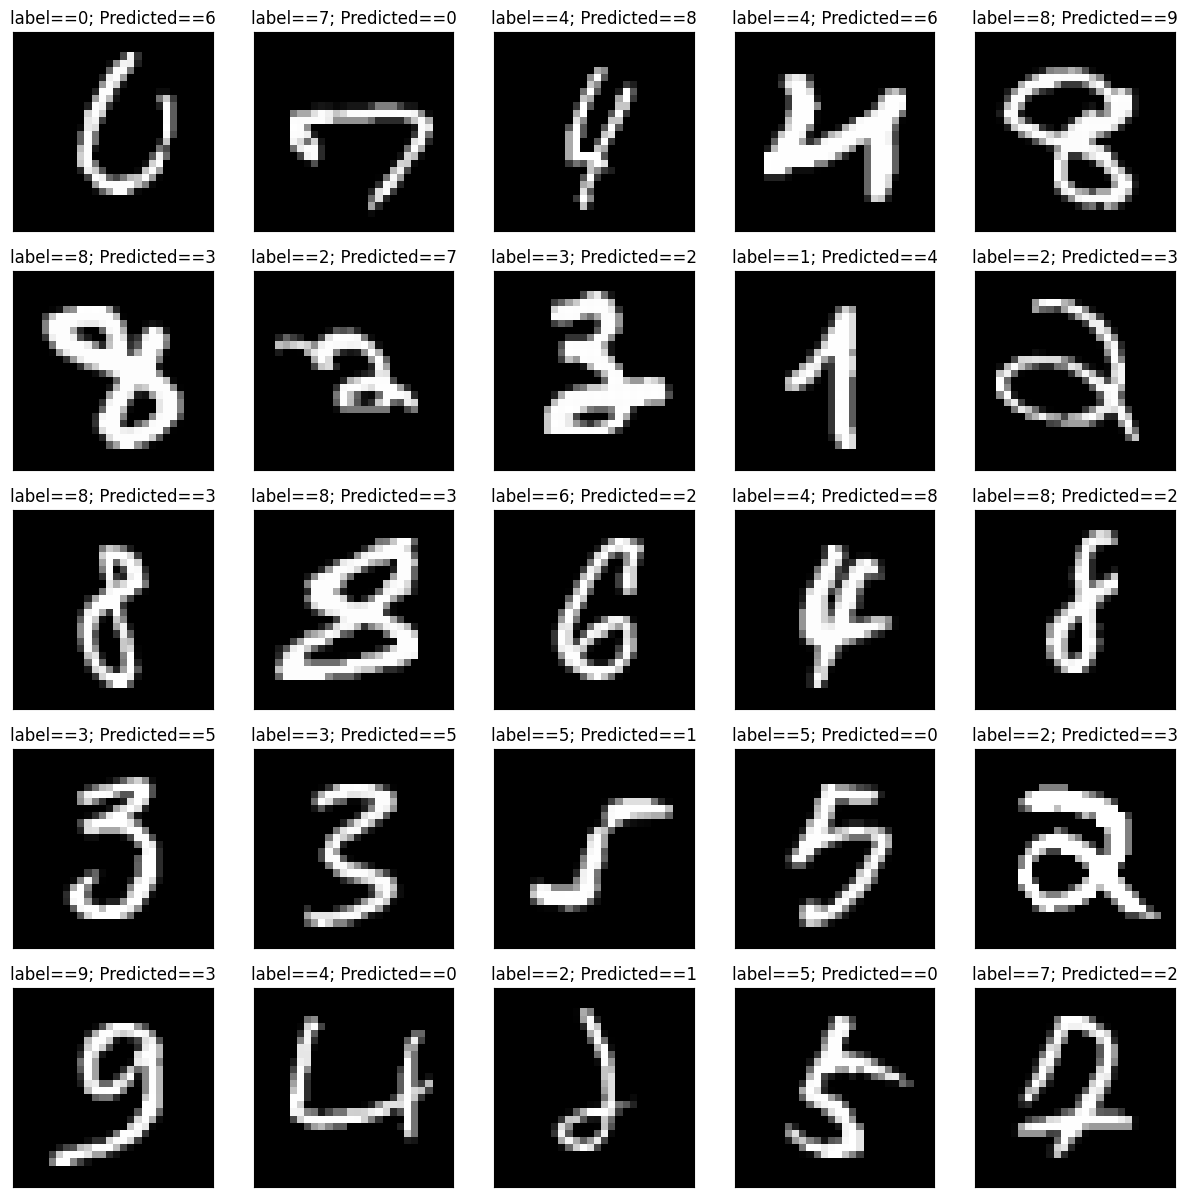

In [21]:
visualize(X_val[y_val!= y_mlp], 
          y_val[y_val!=y_mlp], 
          y_mlp[y_val!=y_mlp], n_rows=5, n_columns=5)

### В реалізації sklearn мало гнучкості. Більш складні архітектури необхідно реалізовувати в PyTorch

In [23]:
class TorchPerceptron(nn.Module):
    def __init__(self, hidden_size=100):
        super(TorchPerceptron, self).__init__()
        self.layer1 = nn.Linear(784, hidden_size)
        self.act1 = nn.Tanh()
        self.layer2 = nn.Linear(hidden_size, 10)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        return x
    
mlp_torch = TorchPerceptron()
torch.softmax( mlp_torch(torch.randn(3,784)), dim=1 ) #модель повертає ймовірності класів, 
#правда, обгорнуті в torch.Tensor замість numpy.ndarray

tensor([[0.0713, 0.0866, 0.0899, 0.0717, 0.0985, 0.1187, 0.1265, 0.0993, 0.1083,
         0.1292],
        [0.0854, 0.1067, 0.1066, 0.1025, 0.0981, 0.1374, 0.0799, 0.0890, 0.1132,
         0.0812],
        [0.1013, 0.0742, 0.1203, 0.0983, 0.0855, 0.1472, 0.1221, 0.0616, 0.1157,
         0.0737]], grad_fn=<SoftmaxBackward0>)

In [24]:
criterion = nn.CrossEntropyLoss()  # Функція середньоквадратичних втрат для задачі регресії
optimizer = torch.optim.SGD(mlp_torch.parameters(), lr=0.01) 

In [25]:
X_train_torch, X_val_torch = torch.tensor(X_train), torch.tensor(X_val)
y_train_torch, y_val_torch = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

for epoch in range(200+1):  # Навчання триває 10 епох (навчальна вибірка проходить через модель 10 разів)
    optimizer.zero_grad()  # Обнулення градієнтів
    outputs = mlp_torch(X_train_torch)  # Зробити передбачення
    loss = criterion(outputs, y_train_torch)  # Розрахунок втрат
    loss.backward()  # Обчислення градієнтів
    optimizer.step()  # Оновлення ваг
    
    y_mlp_torch = torch.argmax( mlp_torch(X_val_torch), dim=1).detach().numpy()
    acc = sum(y_mlp_torch==y_val)/len(y_val)
    if epoch % 20 ==0:
        print(f"Epoch: {epoch}, Accuracy: {round(acc,4)}")

Epoch: 0, Accuracy: 0.118
Epoch: 20, Accuracy: 0.7174
Epoch: 40, Accuracy: 0.8023
Epoch: 60, Accuracy: 0.8321
Epoch: 80, Accuracy: 0.8495
Epoch: 100, Accuracy: 0.8625
Epoch: 120, Accuracy: 0.8729
Epoch: 140, Accuracy: 0.8768
Epoch: 160, Accuracy: 0.8794
Epoch: 180, Accuracy: 0.8812
Epoch: 200, Accuracy: 0.8837


In [26]:
print(classification_report(y_val, y_mlp_torch))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       827
           1       0.95      0.96      0.96       937
           2       0.87      0.85      0.86       835
           3       0.84      0.86      0.85       870
           4       0.89      0.89      0.89       814
           5       0.85      0.77      0.81       759
           6       0.91      0.93      0.92       827
           7       0.91      0.90      0.91       880
           8       0.86      0.83      0.84       813
           9       0.85      0.86      0.85       838

    accuracy                           0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400



Виведемо приклади, де Pytorch-персептрон помилився

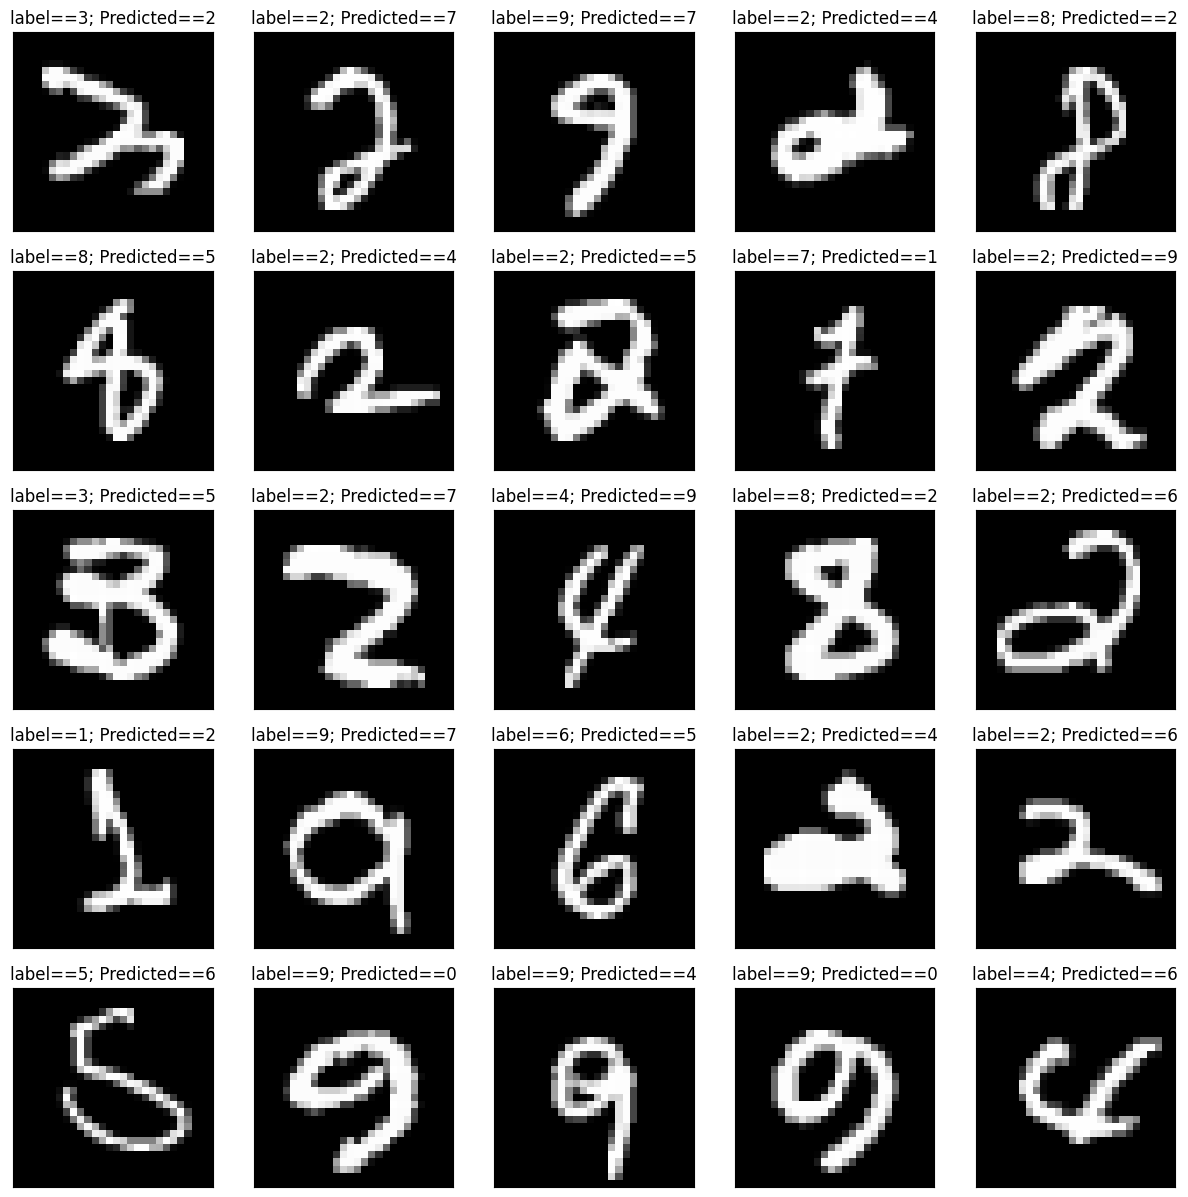

In [27]:
visualize(X_val[y_val!= y_mlp_torch], 
          y_val[y_val!=y_mlp_torch], 
          y_mlp_torch[y_val!=y_mlp_torch], n_rows=5, n_columns=5)